___
<h1><center> Segmentacion de clientes de un distribuiodor - Problema de clustering</center></h1>

___


## Descripcion

El objetivo del problema es separar los clientes de un distribuidor al por mayor en grupos lo mas homogeneos posible pero que se diferencien entre ellos al maximo de cara a realizar acciones dirigidas y distintas para cada uno de los grupos

## Informacion de los datos

- **FRESH:** gasto anual (u. m.) en productos frescos (Continuo).
- **MILK:** gasto anual (u. m.) en productos lácteos (Continuo).
- **GROCERY:** gasto anual (u. m.) en productos comestibles (Continuo).
- **FROZEN:** gasto anual (u. m.) en productos congelados (Continuo).
- **DELICATESSEN:** gasto anual (u. m.) en productos delicatessen (Continuo).
- **CHANNEL:** canal de clientes - Horeca (Hotel/Restaurante/Café) o canal minorista (Nominal).
- **REGION:** región de clientes - Lisbon, Oporto u Otros (Nominal).

Channel y Region son variables categoricas

**Region:**

Lisbon, 77.
Oporto, 47.
Other Region, 316.

**Channel:**

Horeca, 298.
Retail, 142.

In [6]:
from IPython.core.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import boxcox, probplot, norm, shapiro
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.cluster import KMeans
import os
import warnings
warnings.filterwarnings('ignore')

## Definicion de funciones


In [7]:
def comprueba_normalidad(df, return_type='axes', title='Comprobación de normalidad'):
    '''
    '''
    fig_tot = (len(df.columns))
    fig_por_fila = 3.
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+2 ) )
    c = 0 
    shapiro_test = {}
    lambdas = {}
    for i, col in enumerate(df.columns):
        ax = plt.subplot(num_filas, fig_por_fila, i+1)
        probplot(x = df[df.columns[i]], dist=norm, plot=ax)
        plt.title(df.columns[i])
        shapiro_test[df.columns[i]] = shapiro(df[df.columns[i]])
    plt.suptitle(title)
    plt.show()
    shapiro_test = pd.DataFrame(shapiro_test, index=['Test Statistic', 'p-value']).transpose()
    return shapiro_test

## Lectura de datos

In [8]:
X = pd.read_csv('https://masterdatascience.s3.us-east-2.amazonaws.com/6.machine_learning/Wholesale_customers_data.csv')
print(u'- El número de filas en el dataset es: {}'.format(X.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(X.shape[1]))
print(u'- Nombres de las variables: {}'.format(list(X.columns)))
X[:2]

- El número de filas en el dataset es: 440
- El número de columnas en el dataset es: 8
- Nombres de las variables: ['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776


## Categoricas a numericas

In [15]:
X['Channel'].value_counts()

1    298
2    142
Name: Channel, dtype: int64

In [16]:
X['Region'].value_counts()

3    316
1     77
2     47
Name: Region, dtype: int64

In [17]:
# Mapeo los datos

X['Channel'] = X['Channel'].map({1:'Horeca', 2:'Retail'})
X['Region'] = X['Region'].map({3:'Other Region', 2:'Oporto', 1: 'Lisboa'})

In [18]:
X[:2]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,Retail,Other Region,12669,9656,7561,214,2674,1338
1,Retail,Other Region,7057,9810,9568,1762,3293,1776


## Preprocesamiento de datos

### Missing


In [19]:
X.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

## Visualizaciones y correlaciones

### Descriptivos basicos

In [20]:
X.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [22]:
# Se guarda las variables numerias en la variable X_cuants ya que se van a realizar algunas transformaciones
X_cuants = X[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']].copy()

### Boxplot

In [23]:
X_normalizado = (X_cuants-X_cuants.mean())/X_cuants.std()

In [25]:
X_normalizado[:2]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.052873,0.522972,-0.041068,-0.588697,-0.043519,-0.066264
1,-0.390857,0.543839,0.170125,-0.269829,0.086309,0.089050


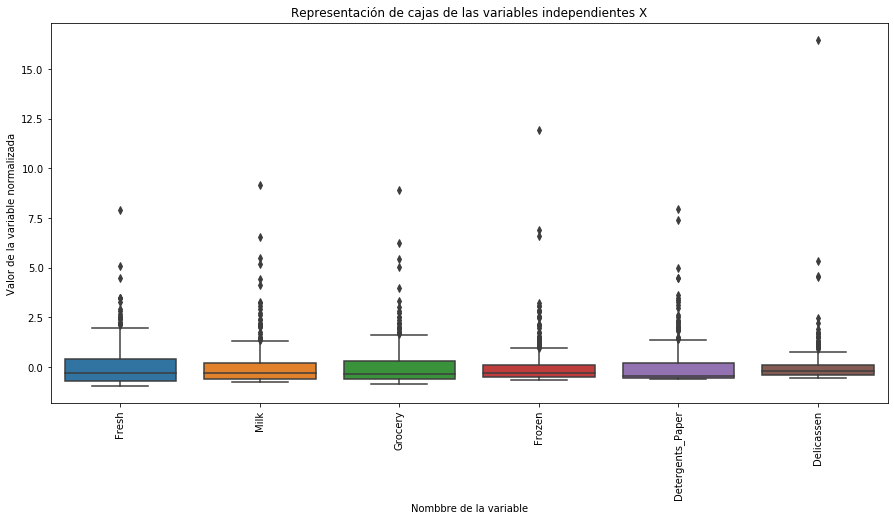

In [26]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombbre de la variable')

Se puede observar que todas las variables tiene outliers

### Histogramas

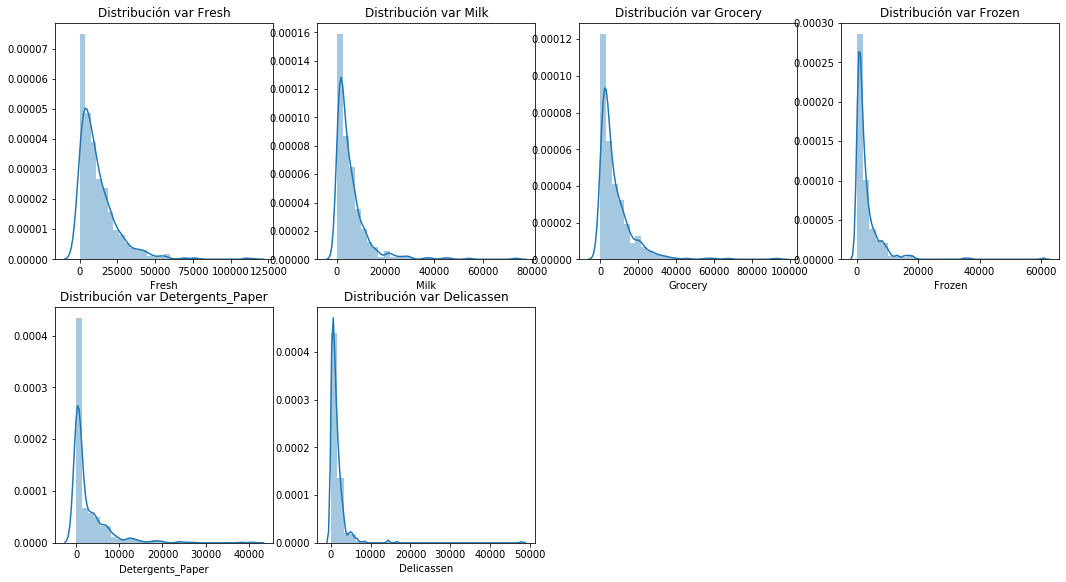

In [27]:
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(X_cuants.columns):
    n+=1
    plt.subplot(4, 4, n)
    sns.distplot(X_cuants[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

### Matriz de correlaciones

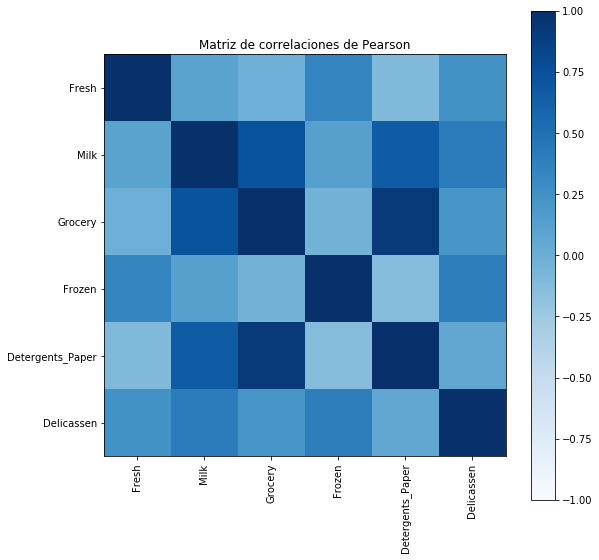

In [28]:
matriz_correlaciones = X_cuants.corr(method='pearson')
n_ticks = len(X_cuants.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), X_cuants.columns, rotation='vertical')
plt.yticks(range(n_ticks), X_cuants.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Matriz de correlaciones de Pearson')

## Transformacion de datos para cumplir las hipotesis

Se va aplicar un algoritmo K-means, los datos deben cumplit una serie de hipotesis:
- Los datos tienen una distribucion normal
- Propenso a outliers

Por lo que se transformaran las varibles para que sigan estas hipotesis

## Normalizacion de datos

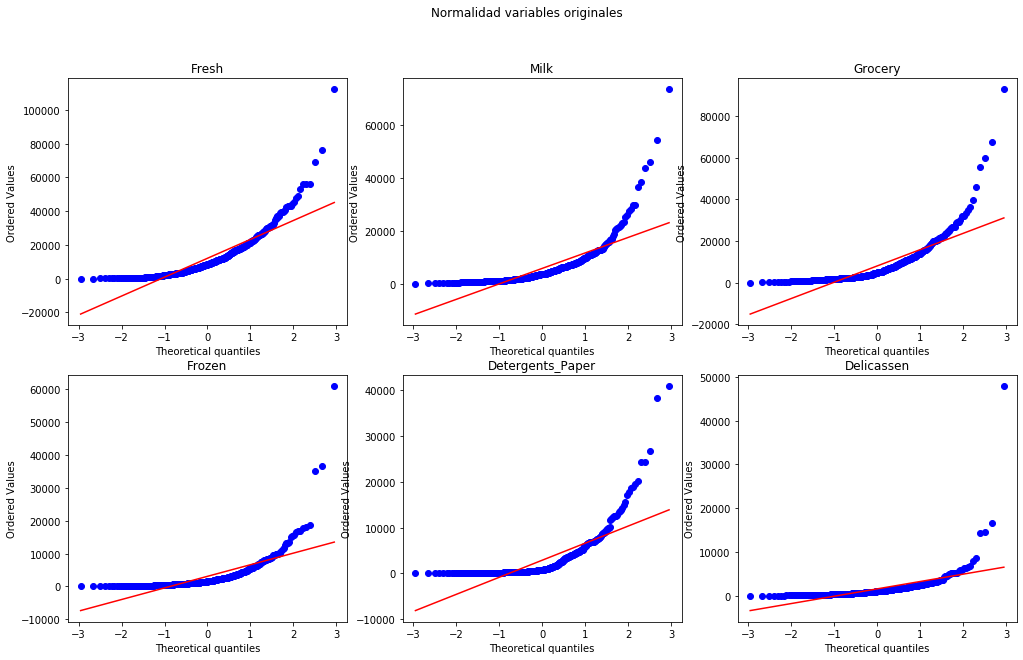

In [31]:
shapiro_test = comprueba_normalidad(X_cuants, title='Normalidad variables originales')

In [32]:
shapiro_test

,Test Statistic,p-value
Fresh,0.781436,7.918286e-24
Milk,0.628334,9.762062e-30
Grocery,0.676231,3.906209e-28
Frozen,0.528297,1.291332e-32
Detergents_Paper,0.605482,1.914593e-30
Delicassen,0.361068,1.753408e-36


In [33]:
# Ahora transformo las variables con una transformación Box-Cox. 
# (comúnmente utilizado para transformar un conjunto de datos que no se distribuye normalmente en uno con 
# una distribución más normal .)

bc = PowerTransformer(method='box-cox')
X_cuants_boxcox = bc.fit_transform(X_cuants)
X_cuants_boxcox = pd.DataFrame(X_cuants_boxcox, columns=X_cuants.columns)

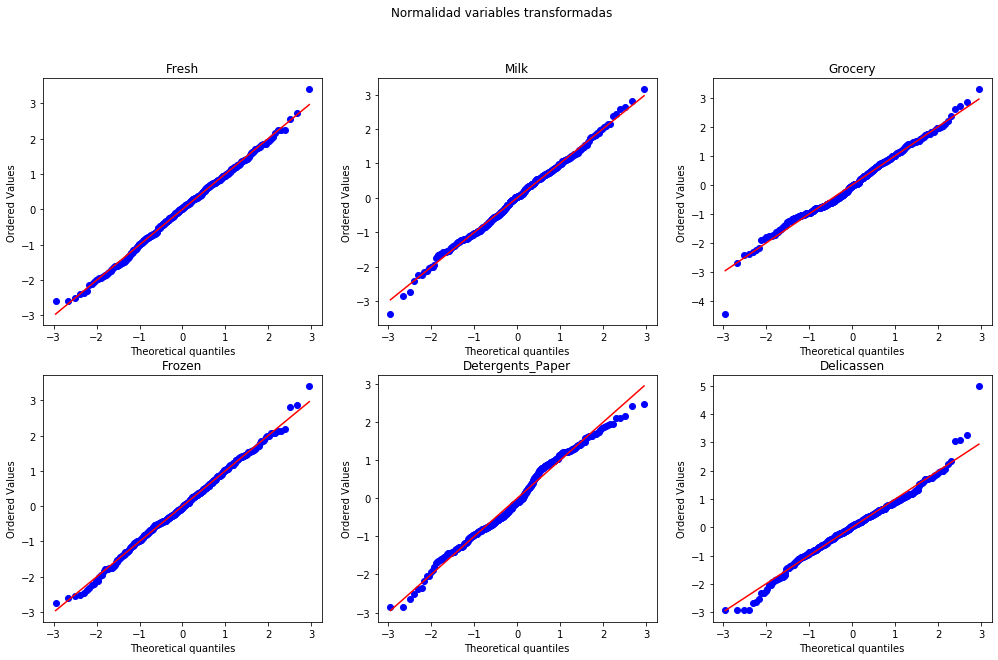

In [34]:
shapiro_test = comprueba_normalidad(X_cuants_boxcox, title='Normalidad variables transformadas')

In [35]:
shapiro_test

,Test Statistic,p-value
Fresh,0.997444,0.737640
Milk,0.996949,0.584253
Grocery,0.989162,0.002425
Frozen,0.997237,0.673468
Detergents_Paper,0.985208,0.000185
Delicassen,0.981869,0.000026


El estadístico de normalidad es muy alto en todas las variables ahora, por lo que continuamos con esta transformada. 

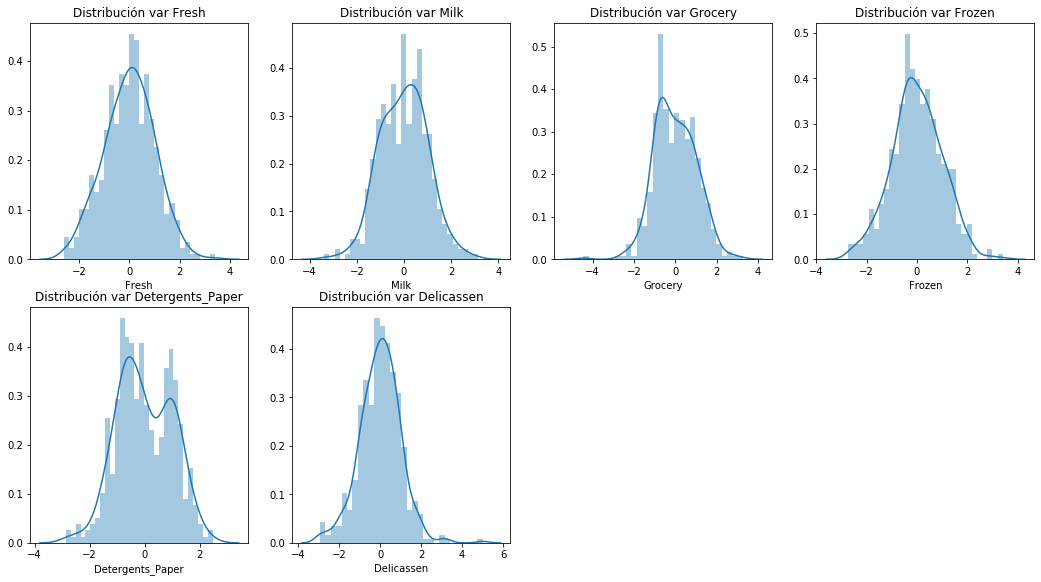

In [36]:
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(X_cuants_boxcox.columns):
    n+=1
    plt.subplot(4, 4, n)
    sns.distplot(X_cuants_boxcox[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

## Tratamiento de outliers

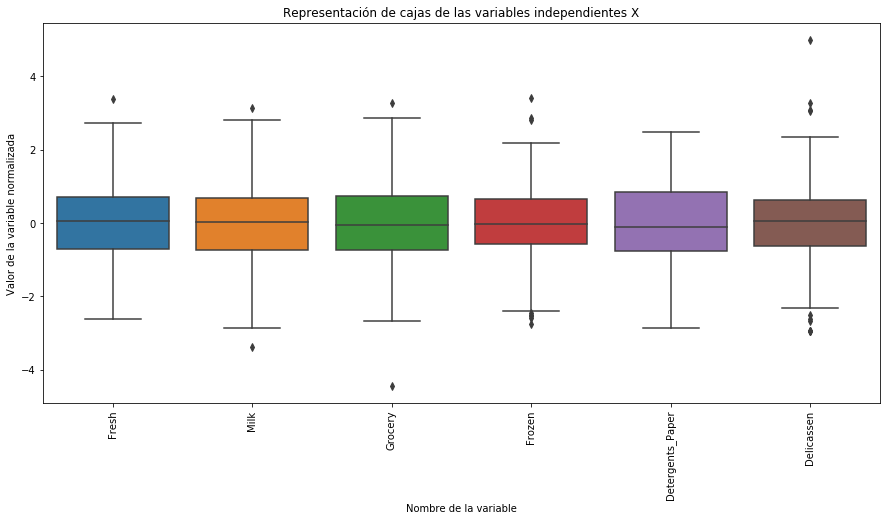

In [37]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_cuants_boxcox)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

In [39]:
# En este caso sustituyo los outliers por los límites inferiores (Q1-1.5IQR) y superiores (Q3+1.5IQR)

for k in list(X_cuants_boxcox.columns):
    IQR = np.percentile(X_cuants_boxcox[k],75) - np.percentile(X_cuants_boxcox[k],25)
    
    limite_superior = np.percentile(X_cuants_boxcox[k],75) + 1.5*IQR
    limite_inferior = np.percentile(X_cuants_boxcox[k],25) - 1.5*IQR
    
    X_cuants_boxcox[k] = np.where(X_cuants_boxcox[k] > limite_superior,limite_superior,X_cuants_boxcox[k])
    X_cuants_boxcox[k] = np.where(X_cuants_boxcox[k] < limite_inferior,limite_inferior,X_cuants_boxcox[k])

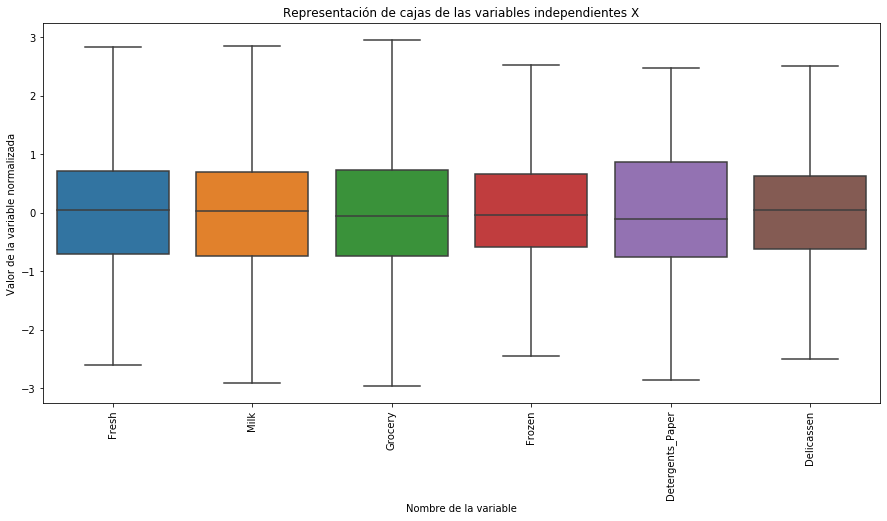

In [40]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_cuants_boxcox)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

Ahora ya no tengo outliers y las variables están distribuidas de forma normal.

## Creo dummies de las variables categoricas

In [41]:
# En df se unen las dos variables, tanto las categoricas iniciales y las numericas transformadas
df  =  pd.concat([X[['Channel','Region']],X_cuants_boxcox],axis=1)
df[:3]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,Retail,Other Region,0.412646,0.979303,0.392937,-1.456705,0.617238,0.335779
1,Retail,Other Region,-0.111180,0.995096,0.626729,0.079718,0.748629,0.599877
2,Retail,Other Region,-0.196043,0.887891,0.408738,0.331996,0.790324,2.245295


In [42]:
# las categóricas las paso a dummies. Es decir, para cada valor de la variable 
# genero una variable binaria con 1s y 0s.

df = pd.get_dummies(df,columns=['Channel','Region'],drop_first=True)
df[:3]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_Retail,Region_Oporto,Region_Other Region
0,0.412646,0.979303,0.392937,-1.456705,0.617238,0.335779,1,0,1
1,-0.111180,0.995096,0.626729,0.079718,0.748629,0.599877,1,0,1
2,-0.196043,0.887891,0.408738,0.331996,0.790324,2.245295,1,0,1


## Escalado previo de los datos

In [43]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_escalado = scaler.fit_transform(df)
X_escalado = pd.DataFrame(X_escalado,columns=df.columns)
X_escalado.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_Retail,Region_Oporto,Region_Other Region
0,0.555805,0.675704,0.566972,0.199988,0.651772,0.567532,1.0,0.0,1.0
1,0.459410,0.678453,0.606514,0.508654,0.676366,0.620280,1.0,0.0,1.0
2,0.443793,0.659790,0.569644,0.559337,0.684170,0.948915,1.0,0.0,1.0
3,0.564108,0.337200,0.474040,0.728423,0.466264,0.621569,0.0,0.0,1.0
4,0.669174,0.577020,0.558857,0.641610,0.604411,0.847771,1.0,0.0,1.0


## Segmentacion utilizando un clustering K-means

En este paso intento obtener el número de grupos óptimo utilizando la regla del codo.

In [44]:
cluster_range = range(1,20)
cluster_wss=[] 
for cluster in cluster_range:
    model = KMeans(cluster)
    model.fit(X_escalado)
    cluster_wss.append(model.inertia_)

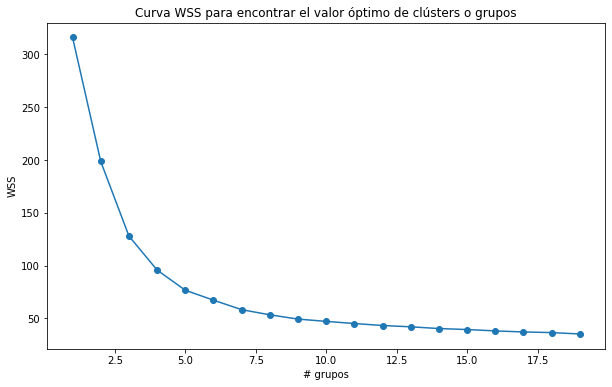

In [45]:
plt.figure(figsize=[10,6])
plt.title('Curva WSS para encontrar el valor óptimo de clústers o grupos')
plt.xlabel('# grupos')
plt.ylabel('WSS')
plt.plot(list(cluster_range),cluster_wss,marker='o')
plt.show()

En la gráfica se supone el punto óptimo cuando la curva crea un codo. En este caso sería sobre 4-6 grupos.

## Utilizo el mejor parametro k=6

El número de grupos lo fijo en 6 pero lo que se suele hacer es probar varios y ver si los resultados finales tienen sentido desde el punto de vista de negocio, como luego comentaré.

### Ajustar modelo

Se ajusta con k=6


In [46]:
model = KMeans(n_clusters=6,random_state=0)
model.fit(X_escalado)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

### Predigo y obtengo clientes con su predicción

Creo un dataframe con todas las variables y una nueva que sea la predicción del clúster asignado:

In [48]:
# Dataframe con variables originales y la predicción
df_total = X.copy()
df_total['cluster']=model.predict(X_escalado)
df_total[:2]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,Retail,Other Region,12669,9656,7561,214,2674,1338,2
1,Retail,Other Region,7057,9810,9568,1762,3293,1776,2


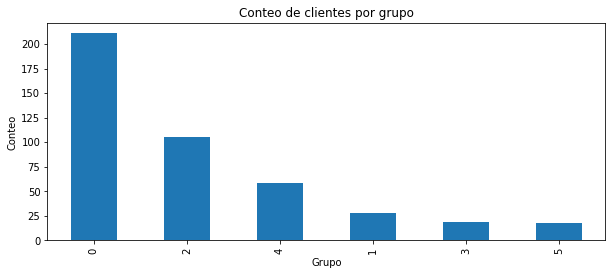

In [49]:
df_total.cluster.value_counts().plot(kind='bar', figsize=(10,4))
plt.title('Conteo de clientes por grupo')
plt.xlabel('Grupo')
_ = plt.ylabel('Conteo')

### Obtener caracteristica

También obtengo un dataframe con las medias de las variables en cada grupo. Esto representaría cada uno de los grupos.

Esto es muy necesario ya que las acciones que el objetivo de este problema sería hacer acciones a cada uno de los grupos por separado. Para ello es muy importante conocer cómo es cada grupo, de cara a accionar de forma distinta.

In [51]:
# Mostrar las medias de cada grupo
descripivos_grupos = df_total.groupby(['cluster'],as_index=False).mean()
descripivos_grupos

,cluster,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0,13878.052133,3486.981043,3886.734597,3656.900474,786.682464,1518.284360
1,1,11650.535714,2304.250000,4395.500000,5745.035714,482.714286,1105.892857
2,2,9831.504762,10981.009524,15953.809524,1513.200000,6899.238095,1826.209524
3,3,7289.789474,9190.789474,16326.315789,1540.578947,8410.263158,1239.000000
4,4,12902.254237,3870.203390,4026.135593,3127.322034,950.525424,1197.152542
5,5,5200.000000,10784.000000,18471.944444,2584.111111,8225.277778,1871.944444


## Obtenemos una representacion de los grupos con PCA

Los grupos obtenidos anteriormente se pueden reducir a una dimensión menor y representarse. En este caso reduzco a dimensión=2, usando el método PCA.

In [52]:
pca2 = PCA(n_components=2)
pc = pca2.fit_transform(X_escalado)
pc_df = pd.DataFrame(pc)
pca = pd.concat([pc_df, df_total['cluster']],axis=1)
pca.columns = ['pc1','pc2','cluster']
pca[:2]

,pc1,pc2,cluster
0,0.736695,-0.260786,2
1,0.731883,-0.249084,2


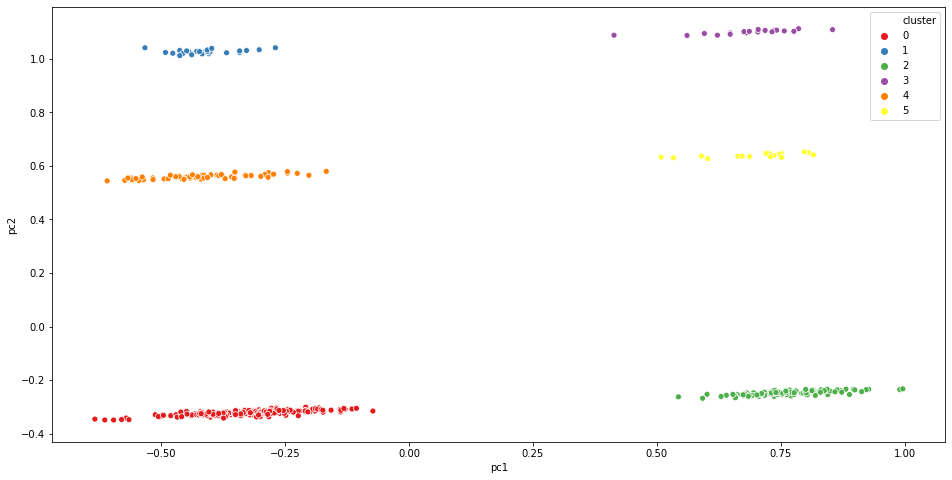

In [54]:
plt.figure(figsize=[16,8])
sns.scatterplot(x='pc1', y='pc2', hue= 'cluster', data=pca, palette='Set1')
plt.show()

Las dos componentes principales muestran que los grupos se separan de manera perfecta entre ellos.

## Explicacion de los grupos usando las medias de cada variable por grupo

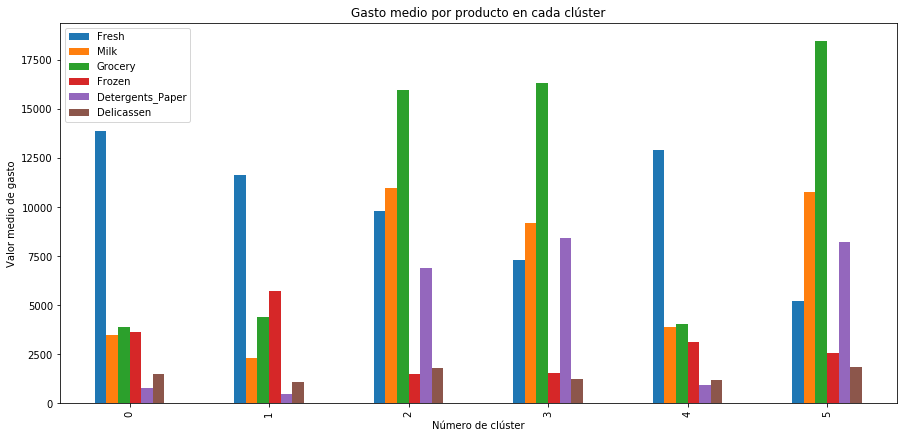

In [55]:
df_total.groupby('cluster').mean().plot(kind='bar', figsize=(15,7))
plt.title('Gasto medio por producto en cada clúster')
plt.xlabel(u'Número de clúster')
_ = plt.ylabel('Valor medio de gasto')